# Automatic scoring of x-ray images

Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools

# keras
from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow.contrib.keras.python.keras.utils.io_utils import HDF5Matrix
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, Activation
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib.keras.python.keras import callbacks


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

Import data as HDF5 Matrix

In [5]:
# one hot encode labels

with h5py.File('/data/joint_scoring/labels_train_combined_regression.h5', 'r') as hf:
    labels_train = hf['labels_train_combined_regression'][:]
    
with h5py.File('/data/joint_scoring/labels_test_regression.h5', 'r') as hf:
    labels_test = hf['labels_test_regression'][:]
    
def cdf(label):
    arr = np.zeros(101)
    arr[int(label):] = 1
    return arr

labels_train = [cdf(x) for x in labels_train]
labels_test = [cdf(x) for x in labels_test]

In [8]:
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

In [10]:
print(labels_train.shape)
print(labels_test.shape)

(210025, 101)
(19709, 101)


In [11]:
with h5py.File('/data/joint_scoring/labels_train_combined_regression_cdf.h5', 'w') as hf:
    hf.create_dataset("labels_train_combined_regression_cdf",  data=labels_train)
    
with h5py.File('/data/joint_scoring/labels_test_regression_cdf.h5', 'w') as hf:
    hf.create_dataset("labels_test_regression_cdf",  data=labels_test)

In [12]:
img_train = HDF5Matrix('/data/joint_scoring/img_train_combined_regression.h5', 'img_train_combined_regression')
img_test = HDF5Matrix('/data/joint_scoring/img_test_regression.h5', 'img_test_regression')

labels_train = HDF5Matrix('/data/joint_scoring/labels_train_combined_regression_cdf.h5', 'labels_train_combined_regression_cdf')
labels_test = HDF5Matrix('/data/joint_scoring/labels_test_regression_cdf.h5', 'labels_test_regression_cdf')

In [13]:
def crps(y_true, y_pred):
    diff = (y_true - y_pred)
    diff_2 = diff * diff
    div = diff_2 / K.ndim(y_true)
    loss = K.sum(div)
    return loss

## 2. Model

In [28]:
def conv_model():
    # create model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255., input_shape=(150, 150, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=101, kernel_initializer="he_normal", activation="softmax"))

    # Compile model
    model.compile(optimizer="adam", loss=crps,
                  metrics=['mae', 'acc'])

    return model

In [29]:
# build the model
model = conv_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_29 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
activation_29 (Activation)   (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_30 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
activation_30 (Activation)   (None, 150, 150, 32)      0         
__________

In [30]:
# create log directory
now = datetime.now
new_folder = '{}'.format(now().strftime('%Y%m%d_%H%M%S'))

In [31]:
print(new_folder)

20171028_235203


In [32]:
desc = "Regression model with CRPS on oversampled data"

with open("/data/joint_scoring/readme.txt", "a") as myfile:
    myfile.write("\n" + new_folder + "    " + desc)

In [33]:
# tensorboard callback
tb_callback = callbacks.TensorBoard(log_dir="/data/joint_scoring/tensorboard/" + new_folder,
                                    histogram_freq=0, write_graph=True,
                                    write_images=True)

In [ ]:
# Fit the model
model.fit(x=img_train, y=labels_train, batch_size=100, epochs=25, verbose=1,
          callbacks=[tb_callback], validation_data=(img_test, labels_test),
          shuffle="batch")

Train on 210025 samples, validate on 19709 samples
Epoch 1/25
210025/210025 [==============================] - 491s - loss: 2998.3500 - mean_absolute_error: 0.6030 - acc: 0.0390 - val_loss: 4694.4508 - val_mean_absolute_error: 0.9397 - val_acc: 0.0106
Epoch 3/25
210025/210025 [==============================] - 491s - loss: 2997.8225 - mean_absolute_error: 0.6030 - acc: 0.0380 - val_loss: 4694.4585 - val_mean_absolute_error: 0.9397 - val_acc: 0.0112
Epoch 5/25
210025/210025 [==============================] - 491s - loss: 2997.6123 - mean_absolute_error: 0.6029 - acc: 0.0378 - val_loss: 4694.2020 - val_mean_absolute_error: 0.9396 - val_acc: 0.0105
Epoch 6/25
210025/210025 [==============================] - 491s - loss: 2997.4104 - mean_absolute_error: 0.6029 - acc: 0.0380 - val_loss: 4694.3030 - val_mean_absolute_error: 0.9397 - val_acc: 0.0110
Epoch 7/25
210025/210025 [==============================] - 491s - loss: 2997.2443 - mean_absolute_error: 0.6029 - acc: 0.0382 - val_loss: 4694.5

In [35]:
# Final evaluation of the model
scores = model.evaluate(img_test, labels_test, verbose=0)
print(scores)

[1502.6216175641225, 0.9396705479223656, 0.011111674869349029]


In [36]:
# Save the model
model.save("/data/joint_scoring/models/" + new_folder + ".h5")

In [44]:
from sklearn.metrics import classification_report
pred = model.predict_classes(img_test)
p = model.predict_proba(img_test)

19648/19709 [============================>.] - ETA: 0s

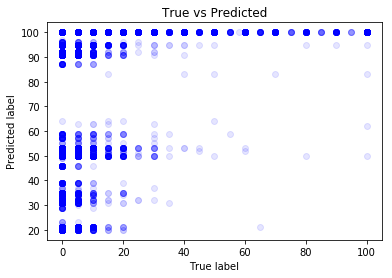

In [53]:
labels_test_reg = HDF5Matrix('/data/joint_scoring/labels_test_regression.h5', 'labels_test_regression')

plt.title("True vs Predicted")
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.scatter(x=labels_test_reg, y=pred, color="blue", alpha=0.1)

plt.show()

In [54]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read('deepxray_regression_oversampled.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open("/data/joint_scoring/notebooks/" + new_folder + ".html", 'w', encoding='utf-8').write(output)